In [201]:
%load_ext zipline


The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [202]:
%zipline ingest --help

Usage: %zipline [OPTIONS]

  Run a backtest for the given algorithm.

Options:
  -f, --algofile FILENAME         The file that contains the algorithm to run.
  -t, --algotext TEXT             The algorithm script to run.
  -D, --define TEXT               Define a name to be bound in the namespace
                                  before executing the algotext. For example
                                  '-Dname=value'. The value may be any python
                                  expression. These are evaluated in order so
                                  they may refer to previously defined names.
  --data-frequency [minute|daily]
                                  The data frequency of the simulation.
                                  [default: daily]
  --capital-base FLOAT            The starting capital for the simulation.
                                  [default: 10000000.0]
  -b, --bundle BUNDLE-NAME        The data bundle to use for the simulation.
                          

In [221]:
%%zipline --bundle nse-bundle --trading-calendar XNSE --start '2002-01-01' --end '2019-07-31' -o nse_weekly.pickle
from zipline.data import bundles
import os
import pandas as pd
from zipline.data.bundles import register, load
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data.data_portal import DataPortal
from zipline.api import schedule_function
from zipline.pipeline.data import Column
from zipline.pipeline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
from trading_calendars.trading_calendar import TradingCalendar
from trading_calendars import get_calendar
import itertools
from zipline.pipeline.filters import StaticAssets
from zipline.utils.events import (
  date_rules,
  time_rules,
  Always,
  ComposedRule,
  Never,
  OncePerDay,
)
from zipline.api import (
  attach_pipeline,
  date_rules,
  order_target_percent,
  pipeline_output,
  record,
  schedule_function,
  symbols,
  symbol,
  sid,
)

start_session=pd.Timestamp('2002-01-01', tz='utc')
end_session=pd.Timestamp('2019-07-31', tz='utc')
import numpy as np
from scipy import stats
from zipline.api import order_target, record, symbol

register(
  'nse-bundle',
  csvdir_equities(
    ["daily"],
    '/Users/niteshchawla/Ownstuff/pythonProjects/btTraderNew/'
  ),
  calendar_name="XNSE",
  start_session=start_session,
  end_session=end_session
)

bundle=load('nse-bundle')
all_assets=bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)
# create a python set
symbols=set(
  str(asset.symbol) for asset in bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids)
)

list_symbols=list(symbols)
# print(type(list_symbols))
# print("list of symbols", list_symbols)
data_por=DataPortal(bundle.asset_finder,
                    get_calendar("XNSE"),
                    bundle.equity_daily_bar_reader.first_trading_day,
                    equity_minute_reader=bundle.equity_minute_bar_reader,
                    equity_daily_reader=bundle.equity_daily_bar_reader,
                    adjustment_reader=bundle.adjustment_reader)

close_prices=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                     pd.Timestamp('2018-09-01', tz='utc'), 'daily')
close_prices_list=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                          pd.Timestamp('2018-09-01', tz='utc'), 'daily')

list_sids=list(bundle.asset_finder.sids)


# print((close_prices))


def _slope(ts):
  x=np.arange(len(ts))
  slope, intercept, r_value, p_value, std_err=stats.linregress(x, ts)
  annualized_slope=(np.power(np.exp(slope), 250)-1)*100
  return annualized_slope*(r_value**2)


def initialize(context):
  """
  Called once at the start of the algorithm.
  """
  # Setting global parameters
  # context.assets = symbol('3MINDIA')
  context.market=symbol('NIFTY500')
  context.market_window=200
  context.momentum_window=90
  context.minimum_momentum=30
  context.number_of_stocks=10
  # --------------------------

  """Set
  up
  pipeline
  engine"""

  # Loader for pricing
  pipeline_loader=USEquityPricingLoader(
    bundle.equity_daily_bar_reader,
    bundle.adjustment_reader,
  )

  def choose_loader(column):
    if column in USEquityPricing.columns:
      return pipeline_loader

    raise ValueError(
      'No PipelineLoader registered for column %s.'%column
    )

  engine=SimplePipelineEngine(
    get_loader=choose_loader,
    calendar=get_calendar("XNSE").all_sessions,
    asset_finder=bundle.asset_finder,
  )

  pipe=make_pipeline()

  results=engine.run_pipeline(pipe,
                              pd.to_datetime('2018-09-03', utc=True),
                              pd.to_datetime('2019-07-31', utc=True))

  # print(results.head(1200))
  context.pipeline_data=results
  # print("type results",type(results))
  # Create our dynamic stock selector.
  attach_pipeline(pipe, 'make_pipeline')

  # Rebalance monthly
  # schedule_function(my_rebalance, date_rules.month_start(), time_rules.market_open(hours=1))

  """close_prices_list=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                          pd.Timestamp('2018-12-03', tz='utc'), 'daily')"""

  # print("type of close prices", type(close_prices_list))
  schedule_function(my_rebalance, date_rules.week_end(days_offset=2))
  #schedule_function(my_rebalance, date_rules.month_end())


#


def make_pipeline():
  """
  This will return the top 500 US stocks by market cap, dynically updated.
  """
  # Base universe set to the Q500US
  base_universe=(StaticAssets(all_assets))

  # print(type(base_universe))
  yesterday_close=close_prices_list

  pipe=Pipeline(
    screen=base_universe,
    columns={
      'close': USEquityPricing.close.latest,
      'volume': USEquityPricing.volume.latest,
      'open': USEquityPricing.open.latest,
    }
  )
  return pipe


def get_change(current, previous):
  if current==previous:
    return 100.0
  try:
    return ((current-previous)/previous)*100.0
  except ZeroDivisionError:
    return 0


def before_trading_start(context, data):
  print("inside before trading start")
  # context.pipeline_data=pipeline_output(name='make_pipeline')


def handle_data(context, data):
  # context.pipeline_data=pipeline_output('make_pipeline')
  # window_1 = data.history(context.assets,'high',1, '1d')
  # print(window_1)
  # schedule_function(my_rebalance(context, data), date_rules.week_end(days_offset=3))
  pass


def my_rebalance(context, data):
  """
  Our monthly rebalancing
  """
  # context.pipeline_data=pipeline_output('us_500')
  # context.output=pipeline_output('us_500')  # update the current top 500 us stocks
  # context.pipeline_data=pipeline_output('us_500')
  algo_run_timestamp=str(context.datetime)+"T00:00.000000000"
  print("has hit rebalance on date", algo_run_timestamp)
  market_history=data.history(context.market, "close", context.market_window, "1d")  ##NIFTY##
  market_price_algo_day=market_history.get(algo_run_timestamp)
  market_sma_200=data.history(context.market, 'price', bar_count=200, frequency="1d").mean()
  market_cond=market_price_algo_day>market_sma_200
  market_chg=get_change(market_price_algo_day, market_sma_200)
  print("market chg is", market_chg)
  market_chg_cond=(market_chg<0.5)
  if (market_chg_cond):
    print(str(algo_run_timestamp))
    print("nothing to buy")
    return

  my_dict={}
  for x in range(len(list_sids)):
    my_dict[x]=sid(list_sids[x])

  context.security_list=list(my_dict.values())

  momentum_list=np.log(data.history(context.security_list, "close", context.momentum_window, "1d")).apply(_slope)

  # print("momentum list is", momentum_list.sort_values(ascending=False))
  ranking_table=momentum_list.sort_values(ascending=False)  # Sorted

  # print("price at a particular time",market_history.get(algo_run_timestamp))

  # print("market history",market_history)
  # market details
  print("Nifty current price and 200Sma", market_price_algo_day, market_sma_200)
  buy_list=ranking_table[:context.number_of_stocks]  # These we want to buy
  print("buy list", buy_list)
  print("context portfolio positions", context.portfolio.positions)
  # Let's trade!
  for security in context.portfolio.positions:
    if security not in buy_list:
      print("making this", security, 0)
      order_target(security, 0)  # If a stock in the portfolio is not in buy list, sell it!

  for security in context.security_list:
    if security in buy_list:
      sma_100=data.history(security, 'price', bar_count=100, frequency="1d").mean()
      sma_50=data.history(security, 'price', bar_count=50, frequency="1d").mean()
      print("security details", security)

      if buy_list[security]<context.minimum_momentum:
        weight=0.0
      else:
        weight=1.0/context.number_of_stocks  # Equal size to keep simple
      cond1=sma_50>sma_100
      cond2=market_price_algo_day>market_sma_200
      print("security 50 and 100 sma", sma_50, sma_100)

      if (cond1 and cond2):
        order_target_percent(security, weight)  # Trade!
        print("ordering this", security)

            
        


<string>:51: UserWarning: Overwriting bundle with name 'nse-bundle'


has hit rebalance on date 2018-10-24 10:00:00+00:00T00:00.000000000
market chg is -8.376977017460241
2018-10-24 10:00:00+00:00T00:00.000000000
nothing to buy
has hit rebalance on date 2018-10-31 10:00:00+00:00T00:00.000000000
market chg is -6.021154406294759
2018-10-31 10:00:00+00:00T00:00.000000000
nothing to buy
has hit rebalance on date 2018-11-06 10:00:00+00:00T00:00.000000000
market chg is -4.604461612431748
2018-11-06 10:00:00+00:00T00:00.000000000
nothing to buy
has hit rebalance on date 2018-11-14 10:00:00+00:00T00:00.000000000
market chg is -3.858513077872215
2018-11-14 10:00:00+00:00T00:00.000000000
nothing to buy
has hit rebalance on date 2018-11-20 10:00:00+00:00T00:00.000000000
market chg is -3.2659372165957343
2018-11-20 10:00:00+00:00T00:00.000000000
nothing to buy
has hit rebalance on date 2018-11-28 10:00:00+00:00T00:00.000000000
market chg is -2.7186083079276595
2018-11-28 10:00:00+00:00T00:00.000000000
nothing to buy
has hit rebalance on date 2018-12-05 10:00:00+00:0

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


 2019-02-27 10:00:00+00:00T00:00.000000000
market chg is -2.6530927749093816
2019-02-27 10:00:00+00:00T00:00.000000000
nothing to buy
has hit rebalance on date 2019-03-06 10:00:00+00:00T00:00.000000000
market chg is 0.500269325957845
Nifty current price and 200Sma 9230.45 9184.502749999996
buy list Equity(478 [VAKRANGEE])     415.946055
Equity(1 [AAVAS])           178.055504
Equity(474 [UJJIVAN])       144.941856
Equity(299 [MANAPPURAM])    143.554167
Equity(263 [KAJARIACER])    119.015295
Equity(49 [BATAINDIA])      117.795389
Equity(365 [PRAJIND])       112.531773
Equity(227 [INOXLEISUR])    105.698317
Equity(436 [SYMPHONY])      103.097011
Equity(149 [GET&D])          98.801578
dtype: float64
context portfolio positions {}
security details Equity(1 [AAVAS])
security 50 and 100 sma 883.9670000000002 808.0774999999998
ordering this Equity(1 [AAVAS])
security details Equity(49 [BATAINDIA])
security 50 and 100 sma 1188.8390000000002 1095.3575000000003
ordering this Equity(49 [BATAINDIA]

Nifty current price and 200Sma 9501.8 9201.136499999999
buy list Equity(478 [VAKRANGEE])     296.956538
Equity(1 [AAVAS])           224.310210
Equity(299 [MANAPPURAM])    193.661605
Equity(365 [PRAJIND])       187.339710
Equity(227 [INOXLEISUR])    168.365696
Equity(30 [ASTRAZEN])       160.707577
Equity(474 [UJJIVAN])       146.141464
Equity(49 [BATAINDIA])      136.199028
Equity(498 [YESBANK])       104.094077
Equity(436 [SYMPHONY])       98.588354
dtype: float64
context portfolio positions {Equity(49 [BATAINDIA]): Position({'asset': Equity(49 [BATAINDIA]), 'amount': 751, 'last_sale_date': Timestamp('2019-03-27 10:00:00+0000', tz='UTC'), 'last_sale_price': 1371.55, 'cost_basis': 1350.323037424072}), Equity(1 [AAVAS]): Position({'asset': Equity(1 [AAVAS]), 'amount': 874, 'last_sale_date': Timestamp('2019-03-27 10:00:00+0000', tz='UTC'), 'last_sale_price': 1143.4, 'cost_basis': 1223.4746370423343}), Equity(227 [INOXLEISUR]): Position({'asset': Equity(227 [INOXLEISUR]), 'amount': 3295, 

Nifty current price and 200Sma 9716.5 9224.261499999999
buy list Equity(30 [ASTRAZEN])       240.419655
Equity(498 [YESBANK])       236.802796
Equity(1 [AAVAS])           227.601986
Equity(478 [VAKRANGEE])     221.624613
Equity(240 [J&KBANK])       215.889629
Equity(299 [MANAPPURAM])    204.216394
Equity(104 [DBL])           175.612288
Equity(227 [INOXLEISUR])    173.930347
Equity(380 [RECLTD])        163.060433
Equity(403 [SHARDACROP])    155.421404
dtype: float64
context portfolio positions {Equity(1 [AAVAS]): Position({'asset': Equity(1 [AAVAS]), 'amount': 880, 'last_sale_date': Timestamp('2019-04-15 10:00:00+0000', tz='UTC'), 'last_sale_price': 1169.9, 'cost_basis': 1220.6130726681931}), Equity(227 [INOXLEISUR]): Position({'asset': Equity(227 [INOXLEISUR]), 'amount': 3199, 'last_sale_date': Timestamp('2019-04-15 10:00:00+0000', tz='UTC'), 'last_sale_price': 317.85, 'cost_basis': 293.6596878055244}), Equity(299 [MANAPPURAM]): Position({'asset': Equity(299 [MANAPPURAM]), 'amount': 85

Nifty current price and 200Sma 9340.25 9251.124499999998
buy list Equity(240 [J&KBANK])      368.642529
Equity(478 [VAKRANGEE])    303.734887
Equity(1 [AAVAS])          270.456543
Equity(104 [DBL])          260.155610
Equity(30 [ASTRAZEN])      248.303337
Equity(429 [SUNTECK])      202.100590
Equity(44 [BALRAMCHIN])    190.444089
Equity(21 [APLAPOLLO])     176.669793
Equity(96 [CREDITACC])     174.337666
Equity(220 [INDIGO])       141.688898
dtype: float64
context portfolio positions {Equity(96 [CREDITACC]): Position({'asset': Equity(96 [CREDITACC]), 'amount': 1917, 'last_sale_date': Timestamp('2019-05-08 10:00:00+0000', tz='UTC'), 'last_sale_price': 498.05, 'cost_basis': 502.85239024517483}), Equity(1 [AAVAS]): Position({'asset': Equity(1 [AAVAS]), 'amount': 835, 'last_sale_date': Timestamp('2019-05-08 10:00:00+0000', tz='UTC'), 'last_sale_price': 1426.6000000000001, 'cost_basis': 1218.0017495100378}), Equity(104 [DBL]): Position({'asset': Equity(104 [DBL]), 'amount': 1856, 'last_sale

Nifty current price and 200Sma 9757.15 9255.395750000001
buy list Equity(1 [AAVAS])           370.940822
Equity(346 [ORIENTCEM])     317.635323
Equity(240 [J&KBANK])       313.453532
Equity(201 [IBREALEST])     286.910345
Equity(350 [PCJEWELLER])    266.963838
Equity(107 [DCMSHRIRAM])    238.062517
Equity(21 [APLAPOLLO])      205.315120
Equity(429 [SUNTECK])       200.219874
Equity(220 [INDIGO])        194.542451
Equity(169 [GRUH])          185.235024
dtype: float64
context portfolio positions {Equity(1 [AAVAS]): Position({'asset': Equity(1 [AAVAS]), 'amount': 685, 'last_sale_date': Timestamp('2019-05-29 10:00:00+0000', tz='UTC'), 'last_sale_price': 1413.45, 'cost_basis': 1222.7440832426794}), Equity(107 [DCMSHRIRAM]): Position({'asset': Equity(107 [DCMSHRIRAM]), 'amount': 1650, 'last_sale_date': Timestamp('2019-05-29 10:00:00+0000', tz='UTC'), 'last_sale_price': 551.1, 'cost_basis': 582.4420749999999}), Equity(44 [BALRAMCHIN]): Position({'asset': Equity(44 [BALRAMCHIN]), 'amount': 678

Nifty current price and 200Sma 9551.35 9256.609000000002
buy list Equity(201 [IBREALEST])     476.000005
Equity(346 [ORIENTCEM])     445.873927
Equity(1 [AAVAS])           278.114795
Equity(229 [INTELLECT])     259.603013
Equity(175 [GUJGASLTD])     224.690981
Equity(220 [INDIGO])        212.066950
Equity(107 [DCMSHRIRAM])    196.704013
Equity(249 [JKCEMENT])      181.484297
Equity(297 [MAHSCOOTER])    178.705552
Equity(261 [JUSTDIAL])      167.085185
dtype: float64
context portfolio positions {Equity(1 [AAVAS]): Position({'asset': Equity(1 [AAVAS]), 'amount': 643, 'last_sale_date': Timestamp('2019-06-18 10:00:00+0000', tz='UTC'), 'last_sale_price': 1499.75, 'cost_basis': 1226.1812749273035}), Equity(201 [IBREALEST]): Position({'asset': Equity(201 [IBREALEST]), 'amount': 8196, 'last_sale_date': Timestamp('2019-06-18 10:00:00+0000', tz='UTC'), 'last_sale_price': 112.4, 'cost_basis': 125.13071880490483}), Equity(21 [APLAPOLLO]): Position({'asset': Equity(21 [APLAPOLLO]), 'amount': 587, '

Nifty current price and 200Sma 9757.3 9244.190250000005
buy list Equity(201 [IBREALEST])     257.544531
Equity(229 [INTELLECT])     225.296942
Equity(297 [MAHSCOOTER])    224.491111
Equity(346 [ORIENTCEM])     223.448935
Equity(363 [PNCINFRA])      212.878775
Equity(1 [AAVAS])           191.694740
Equity(183 [HDFCAMC])       167.335076
Equity(175 [GUJGASLTD])     162.002590
Equity(261 [JUSTDIAL])      161.314232
Equity(484 [VINATIORGA])    153.791828
dtype: float64
context portfolio positions {Equity(1 [AAVAS]): Position({'asset': Equity(1 [AAVAS]), 'amount': 601, 'last_sale_date': Timestamp('2019-07-03 10:00:00+0000', tz='UTC'), 'last_sale_price': 1512.7, 'cost_basis': 1226.181344810831}), Equity(261 [JUSTDIAL]): Position({'asset': Equity(261 [JUSTDIAL]), 'amount': 1185, 'last_sale_date': Timestamp('2019-07-03 10:00:00+0000', tz='UTC'), 'last_sale_price': 788.15, 'cost_basis': 723.5126121308018}), Equity(201 [IBREALEST]): Position({'asset': Equity(201 [IBREALEST]), 'amount': 7724, 'la

Nifty current price and 200Sma 9543.35 9236.447000000002
buy list Equity(363 [PNCINFRA])      164.009023
Equity(229 [INTELLECT])     163.908549
Equity(183 [HDFCAMC])       147.170070
Equity(297 [MAHSCOOTER])    144.826522
Equity(484 [VINATIORGA])    143.161350
Equity(443 [TATAGLOBAL])    135.434884
Equity(261 [JUSTDIAL])      130.054989
Equity(1 [AAVAS])           128.841868
Equity(201 [IBREALEST])     105.118422
Equity(41 [BAJFINANCE])     103.611697
dtype: float64
context portfolio positions {Equity(1 [AAVAS]): Position({'asset': Equity(1 [AAVAS]), 'amount': 588, 'last_sale_date': Timestamp('2019-07-17 10:00:00+0000', tz='UTC'), 'last_sale_price': 1511.0, 'cost_basis': 1226.1813668171208}), Equity(261 [JUSTDIAL]): Position({'asset': Equity(261 [JUSTDIAL]), 'amount': 1136, 'last_sale_date': Timestamp('2019-07-17 10:00:00+0000', tz='UTC'), 'last_sale_price': 747.0500000000001, 'cost_basis': 723.5126549650323}), Equity(201 [IBREALEST]): Position({'asset': Equity(201 [IBREALEST]), 'amoun

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-10-24 10:00:00+00:00,NaN,0.000000,NaN,-0.030299,NaN,NaN,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,1,[],0.0
2018-10-25 10:00:00+00:00,0.000000,0.000000,0.000000,-0.012902,0.541484,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,2,[],0.0
2018-10-26 10:00:00+00:00,0.000000,0.000000,0.000000,-0.030262,0.396907,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,3,[],0.0
2018-10-29 10:00:00+00:00,0.000000,0.000000,0.000000,-0.035635,0.325985,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,4,[],0.0
2018-10-30 10:00:00+00:00,0.000000,0.000000,0.000000,-0.021344,0.328610,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,5,[],0.0
2018-10-31 10:00:00+00:00,0.000000,0.000000,0.000000,-0.010891,0.309201,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,6,[],0.0
2018-11-01 10:00:00+00:00,0.000000,0.000000,0.000000,-0.000365,0.291758,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,7,[],0.0
2018-11-02 10:00:00+00:00,0.000000,0.000000,0.000000,-0.006286,0.272218,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,8,[],0.0
2018-11-05 10:00:00+00:00,0.000000,0.000000,0.000000,-0.000804,0.256725,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,9,[],0.0
2018-11-06 10:00:00+00:00,0.000000,0.000000,0.000000,0.005519,0.244100,0.000000,0.000000,1.000000e+07,0.00,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,10,[],0.0


In [222]:
import pandas as pd
perf = pd.read_pickle('nse_weekly.pickle') # read in perf DataFrame

In [223]:
perf.to_csv("results.csv")

In [224]:
for items in perf.orders.iteritems():
    if(items[1]):
        print(items)
     
      
        

(Timestamp('2019-03-06 10:00:00+0000', tz='UTC'), [{'filled': 0, 'sid': Equity(1 [AAVAS]), 'created': Timestamp('2019-03-06 10:00:00+0000', tz='UTC'), 'amount': 857, 'id': 'a8aefdbcb8644acc9c1619807a7c4ca6', 'limit_reached': False, 'status': 0, 'reason': None, 'dt': Timestamp('2019-03-06 10:00:00+0000', tz='UTC'), 'stop_reached': False, 'commission': 0, 'stop': None, 'limit': None}, {'filled': 0, 'sid': Equity(49 [BATAINDIA]), 'created': Timestamp('2019-03-06 10:00:00+0000', tz='UTC'), 'amount': 743, 'id': 'ab9f7aadff7d422191ef14e892a5d9a0', 'limit_reached': False, 'status': 0, 'reason': None, 'dt': Timestamp('2019-03-06 10:00:00+0000', tz='UTC'), 'stop_reached': False, 'commission': 0, 'stop': None, 'limit': None}, {'filled': 0, 'sid': Equity(149 [GET&D]), 'created': Timestamp('2019-03-06 10:00:00+0000', tz='UTC'), 'amount': 3382, 'id': 'dfa5d6983c154ac6bedac9f5762682e6', 'limit_reached': False, 'status': 0, 'reason': None, 'dt': Timestamp('2019-03-06 10:00:00+0000', tz='UTC'), 'stop_

In [207]:
# transactions
for items in perf.transactions.iteritems():
    if(items[1]):
        print(items)
        
        
    

(Timestamp('2019-04-01 10:00:00+0000', tz='UTC'), [{'amount': 865, 'dt': Timestamp('2019-04-01 10:00:00+0000', tz='UTC'), 'sid': Equity(1 [AAVAS]), 'commission': None, 'price': 1161.5805, 'order_id': 'b8ed3f5997044fe68da52e705f43b3fe'}, {'amount': 3635, 'dt': Timestamp('2019-04-01 10:00:00+0000', tz='UTC'), 'sid': Equity(498 [YESBANK]), 'commission': None, 'price': 276.03795, 'order_id': 'f2f78ca88a4840b6ac4b93611ac62763'}, {'amount': 3035, 'dt': Timestamp('2019-04-01 10:00:00+0000', tz='UTC'), 'sid': Equity(227 [INOXLEISUR]), 'commission': None, 'price': 325.5627, 'order_id': '7748838c53cb4f5d923417c9edf86f37'}, {'amount': 19880, 'dt': Timestamp('2019-04-01 10:00:00+0000', tz='UTC'), 'sid': Equity(478 [VAKRANGEE]), 'commission': None, 'price': 51.175575, 'order_id': '676710ac7e684165803049c24eb43e0f'}, {'amount': 711, 'dt': Timestamp('2019-04-01 10:00:00+0000', tz='UTC'), 'sid': Equity(49 [BATAINDIA]), 'commission': None, 'price': 1388.0436750000001, 'order_id': '66b07d1a52b3450fa5dc1

In [225]:
for items in perf.pnl.iteritems():
    if(items[1]):
       
        print(items)
        


(Timestamp('2019-03-07 10:00:00+0000', tz='UTC'), -5076.481350000948)
(Timestamp('2019-03-08 10:00:00+0000', tz='UTC'), 29240.85000000149)
(Timestamp('2019-03-11 10:00:00+0000', tz='UTC'), 83956.40000000037)
(Timestamp('2019-03-12 10:00:00+0000', tz='UTC'), 92606.05000000075)
(Timestamp('2019-03-13 10:00:00+0000', tz='UTC'), -61651.20000000112)
(Timestamp('2019-03-14 10:00:00+0000', tz='UTC'), 37116.814199998975)
(Timestamp('2019-03-15 10:00:00+0000', tz='UTC'), -107332.95000000112)
(Timestamp('2019-03-18 10:00:00+0000', tz='UTC'), -1619.949999999255)
(Timestamp('2019-03-19 10:00:00+0000', tz='UTC'), 242.19999999925494)
(Timestamp('2019-03-20 10:00:00+0000', tz='UTC'), 14966.626424999908)
(Timestamp('2019-03-22 10:00:00+0000', tz='UTC'), -12385.449999999255)
(Timestamp('2019-03-25 10:00:00+0000', tz='UTC'), -140267.1499999985)
(Timestamp('2019-03-26 10:00:00+0000', tz='UTC'), 69964.14999999851)
(Timestamp('2019-03-27 10:00:00+0000', tz='UTC'), 208922.40000000037)
(Timestamp('2019-03-28

Text(0, 0.5, 'portfolio value in rupees')

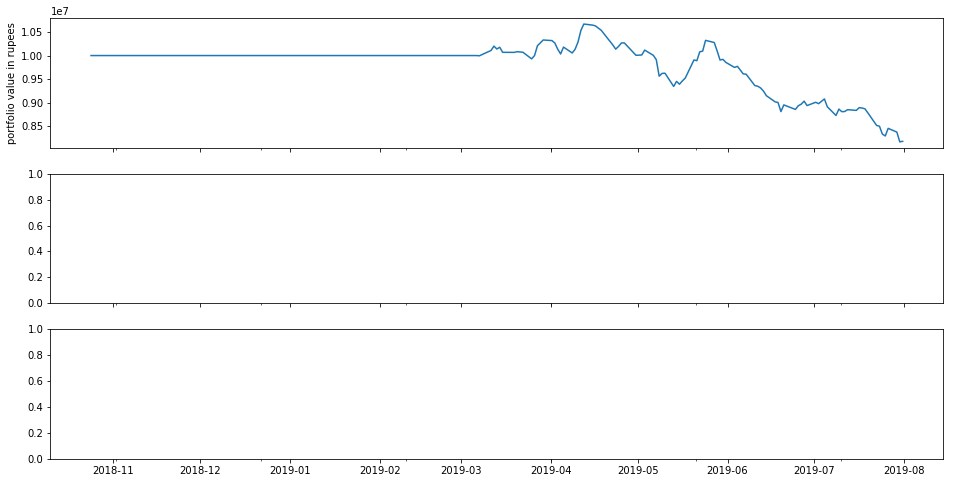

In [233]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])
perf.portfolio_value.plot(ax=ax[0])
ax[0].set_ylabel('portfolio value in rupees')

#asset


In [227]:


# mark transactions
perf_trans = perf.loc[[t != [] for t in perf.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]


In [232]:
for b in buys.transactions:
    print(b)

[{'amount': 3148, 'dt': Timestamp('2019-03-07 10:00:00+0000', tz='UTC'), 'sid': Equity(474 [UJJIVAN]), 'commission': None, 'price': 319.85985, 'order_id': 'd406567927ac4e408aa10db44bd65c5e'}, {'amount': 857, 'dt': Timestamp('2019-03-07 10:00:00+0000', tz='UTC'), 'sid': Equity(1 [AAVAS]), 'commission': None, 'price': 1226.8131, 'order_id': 'a8aefdbcb8644acc9c1619807a7c4ca6'}, {'amount': 3432, 'dt': Timestamp('2019-03-07 10:00:00+0000', tz='UTC'), 'sid': Equity(227 [INOXLEISUR]), 'commission': None, 'price': 293.44665000000003, 'order_id': '498808b923c843269f89ccbdb3ef14c7'}, {'amount': 757, 'dt': Timestamp('2019-03-07 10:00:00+0000', tz='UTC'), 'sid': Equity(436 [SYMPHONY]), 'commission': None, 'price': 1314.0567, 'order_id': '1e0bb893998d4ee2aed19772b50cb528'}, {'amount': 3382, 'dt': Timestamp('2019-03-07 10:00:00+0000', tz='UTC'), 'sid': Equity(149 [GET&D]), 'commission': None, 'price': 295.397625, 'order_id': 'dfa5d6983c154ac6bedac9f5762682e6'}, {'amount': 1779, 'dt': Timestamp('2019

In [230]:
sells

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2019-03-14 10:00:00+00:00,0.023339,0.017619,0.044380,0.040168,0.201491,0.006629,78773.414200,19236.232850,10156956.20,10156956.20,...,0.0,0.0,0,4.645873,-59537.181350,10198612.80,10198612.80,98,"[{'amount': -196, 'dt': 2019-03-14 10:00:00+00...",0.0
2019-04-04 10:00:00+00:00,0.055799,0.003347,0.008478,0.050573,0.192376,0.004489,24621.234650,8198.552425,10025271.45,10025271.45,...,0.0,0.0,0,0.239525,-16422.682225,10151691.20,10151691.20,112,"[{'amount': -17, 'dt': 2019-04-04 10:00:00+00:...",0.0
2019-05-02 10:00:00+00:00,0.094902,0.001237,0.006224,0.074222,0.180981,0.004395,99969.415750,-990.646950,10013361.90,10013361.90,...,0.0,0.0,0,0.099097,-100960.062700,10106396.65,10106396.65,128,"[{'amount': -173, 'dt': 2019-05-02 10:00:00+00...",0.0
2019-05-23 10:00:00+00:00,0.128225,0.009420,0.020521,0.040871,0.179357,0.048256,34271.594459,117196.036734,9977003.30,9977003.30,...,0.0,0.0,0,0.267763,82924.442275,9997148.80,9997148.80,143,"[{'amount': -1919, 'dt': 2019-05-23 10:00:00+0...",0.0
2019-06-13 10:00:00+00:00,0.136750,-0.075699,-0.123604,0.059145,0.175663,0.061312,45215.162325,8447.124688,9234562.45,9234562.45,...,0.0,0.0,0,-1.132510,-36768.037637,9347626.05,9347626.05,157,"[{'amount': -57, 'dt': 2019-06-13 10:00:00+00:...",0.0
2019-06-19 10:00:00+00:00,0.139168,-0.119102,-0.196117,0.071873,0.173934,0.059422,-76626.899425,-68179.774737,8877155.90,8877155.90,...,0.0,0.0,0,-1.750739,8447.124688,8994213.65,8994213.65,161,"[{'amount': -42, 'dt': 2019-06-19 10:00:00+00:...",0.0
2019-07-04 10:00:00+00:00,0.139357,-0.092179,-0.143016,0.099781,0.170299,0.066061,-11514.050425,10961.166838,9067252.80,9067252.80,...,0.0,0.0,0,-1.249829,22475.217263,9004619.10,9004619.10,171,"[{'amount': -4, 'dt': 2019-07-04 10:00:00+00:0...",0.0
2019-07-11 10:00:00+00:00,0.142593,-0.118940,-0.182279,0.101658,0.168111,0.073126,-38397.081900,-27435.915062,8838040.10,8838040.10,...,0.0,0.0,0,-1.553836,10961.166838,8796078.00,8796078.00,176,"[{'amount': -9, 'dt': 2019-07-11 10:00:00+00:0...",0.0
2019-07-18 10:00:00+00:00,0.141005,-0.113321,-0.168042,0.099891,0.166149,0.072147,12817.908475,-14618.006587,8881404.40,8881404.40,...,0.0,0.0,0,-1.449576,-27435.915062,8912948.25,8912948.25,181,"[{'amount': -19, 'dt': 2019-07-18 10:00:00+00:...",0.0
